In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def detect_edges(filename_in: str, filename_out: str):
    img = cv2.imread(filename_in)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    img[dst > 0.01 * dst.max()] = [0, 0, 255]

    cv2.imwrite(filename_out, img)

In [8]:
def align_img(image_to_align: str, reference_image: str, max_features, good_match_percent):
    MIN_MATCH_COUNT = 10

    align_img = cv2.imread(image_to_align, cv2.IMREAD_GRAYSCALE)
    ref_img = cv2.imread(reference_image, cv2.IMREAD_GRAYSCALE)

    sift = cv2.SIFT_create(nfeatures=max_features)

    kp1, desc1 = sift.detectAndCompute(align_img, None)
    kp2, desc2 = sift.detectAndCompute(ref_img, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)

    good_matches = [m for m, n in matches if m.distance < good_match_percent * n.distance]
    if len(good_matches) > MIN_MATCH_COUNT:
        src_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
        matches_mask = mask.ravel().tolist()

        h, w = align_img.shape
        aligned = cv2.warpPerspective(align_img, M, (w, h))

        cv2.imwrite("out/aligned.png", aligned)
    else:
        print(f"Not enough matches found: {len(good_matches)}/{MIN_MATCH_COUNT}")
        matches_mask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=None,
                       matchesMask=matches_mask,
                       flags=2)
    
    img3 = cv2.drawMatches(align_img, kp1, ref_img, kp2, good_matches, None, **draw_params)

    cv2.imwrite('out/matches.png', img3)

    plt.title('Matches')
    plt.imshow(img3, cmap='gray')
    plt.show()

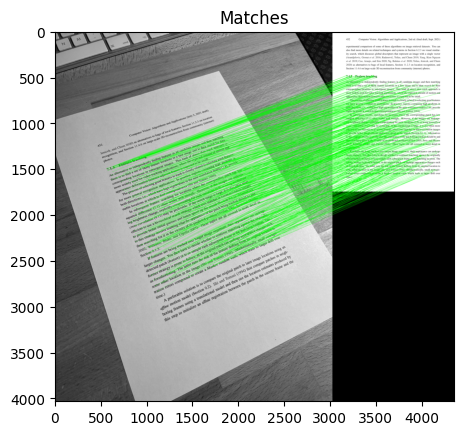

In [9]:
detect_edges('reference_img.png', 'out/harris.png')
align_img('align_this.jpg', 'reference_img.png', 5_000_000, 0.7)

In [ ]:
from PIL import Image

image_paths = ['out/harris.png', 'out/matches.png', 'out/aligned.png']
images = [Image.open(p).convert("RGB") for p in image_paths]
if images:
    images[0].save("out/results.pdf", save_all=True, append_images=images[1:])
